## Logistic Regression, Bayes and EM


In [24]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Function for ploting the decision boundaries of a model
def plot_decision_regions(X, y, classifier, resolution=0.01, title=""):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.title(title)
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.show()

## Reading the data

In [26]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [ ]:
#first graph first feature, first 1000 datapoints second graph first feature, 
#all data points third graph both features first 1000 datapoints fourth graph both features all datapoints

In [27]:
def visualize_data(X, y, title_prefix=""):
    if title_prefix is None or title_prefix == "":
        title_prefix = ""
    else:
        title_prefix = f"{title_prefix} - "

    # prepare data
    classes = np.unique(y_training)
    X_1000 = X[:1000, :]
    y_1000 = y[:1000]

    # hist for first feature - first 1000 data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of first 1000 data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # hist for first feature - all data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X[y == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of all data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # scatter for both features - first 1000 data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for first 1000 data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.show()

    # scatter for both features - all data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X[y == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for all data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.legend()
    plt.show()


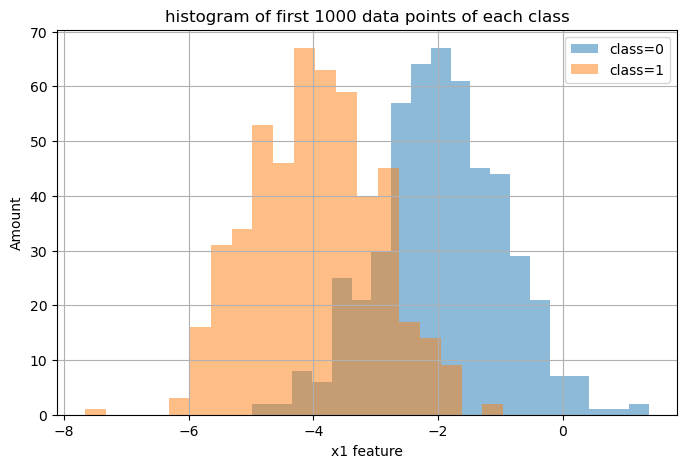

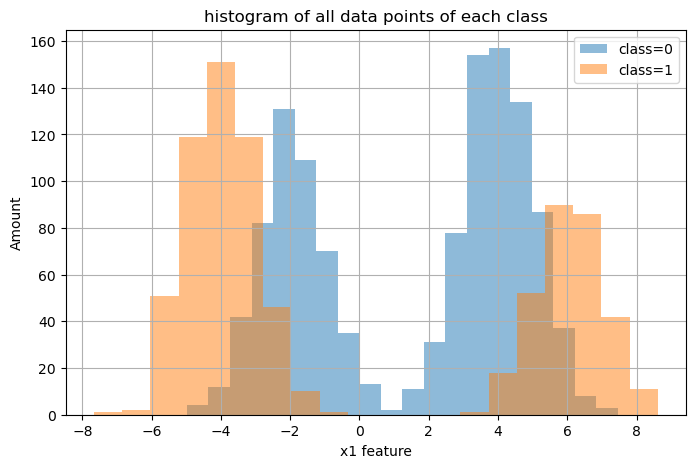

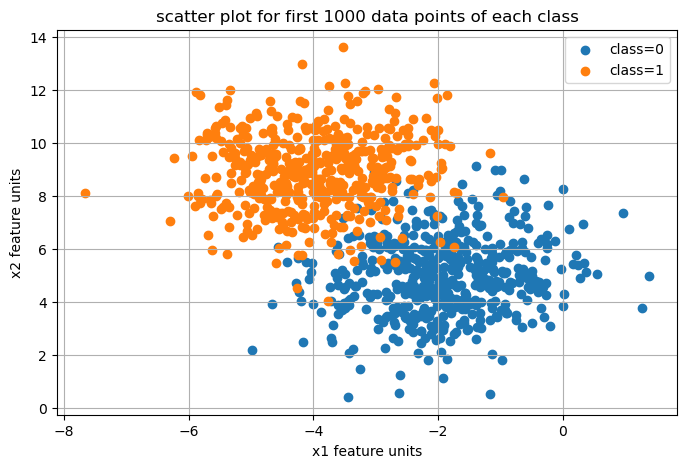

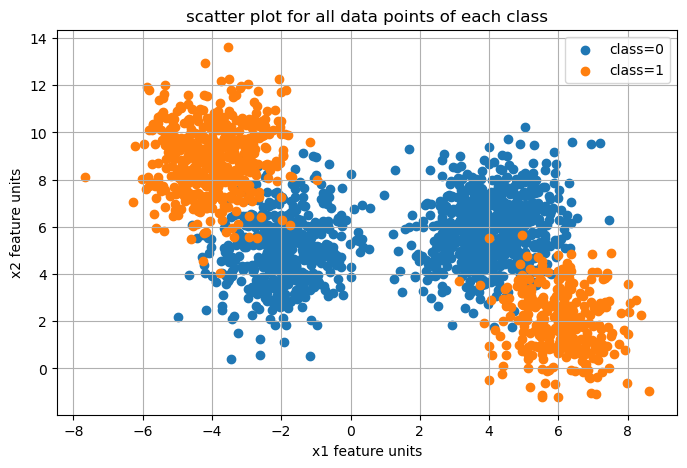

In [28]:
visualize_data(X_training, y_training)

## Logistic Regression

In [29]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """

    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        # model parameters
        self.theta = None

        # iterations history
        self.Js = []
        self.thetas = []
       
    def compute_cost(self, X, y):
        hypothesis = 1 / (1 + np.exp(-np.dot(X, self.theta.T))) 
        J = (-1 / len(X)) * (np.sum((y * np.log(hypothesis)) + (1 - y) * (np.log(1 - hypothesis))))
        return J
    
        
    def efficient_gradient_descent(self, X, y):
             
        for i in range(self.n_iter):
            hypothesis = 1 / (1 + np.exp(-np.dot(X, self.theta.T))) 
            self.Js.append(self.compute_cost(X, y))

            if(i>0 and (self.Js[i - 1] - self.Js[i]) < self.eps):
                break
                
            #summation of the products is also done in the np.dot operation.
            gradient = np.dot(X.T, (hypothesis - y)) / y.size    
            self.theta -= self.eta * gradient

    def fit(self, X, y):
        """
        Fit training data (the learning phase).
        Update the theta vector in each iteration using gradient descent.
        Store the theta vector in self.thetas.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        The learned parameters must be saved in self.theta.
        This function has no return value.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        # set random seed
        np.random.seed(self.random_state)
        X = np.column_stack((np.ones(len(X)), X))
        
        np.random.seed(self.random_state)
        self.theta = np.random.random(size=3)
        self.efficient_gradient_descent(X, y)
    def predict(self, X):
        """
        Return the predicted class labels for a given instance.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
        """
        preds = []
        for i in range(len(X)):
            temp = np.insert(X[i],0,1)
            hypothesisPrediction = 1 / (1 + np.exp(np.dot(temp,-self.theta.T))) 
            if (hypothesisPrediction > 0.5):
                preds.append(1)
            else:
                preds.append(0)        
        return np.array(preds)

In [30]:
# test lor class on all the data
lor = LogisticRegressionGD()
lor.fit(X_training, y_training)

predictions_x_train = lor.predict(X_training)
predictions_x_test = lor.predict(X_test)

## Cross Validation

In [31]:
def cross_validation(X, y, folds, algo, random_state):
    """
    This function performs cross validation as seen in class.

    1. shuffle the data and creates folds
    2. train the model on each fold
    3. calculate aggregated metrics

    Parameters
    ----------
    X : {array-like}, shape = [n_examples, n_features]
      Training vectors, where n_examples is the number of examples and
      n_features is the number of features.
    y : array-like, shape = [n_examples]
      Target values.
    folds : number of folds (int)
    algo : an object of the classification algorithm
    random_state : int
      Random number generator seed for random weight
      initialization.

    Returns the cross validation accuracy.
    """

    cv_accuracy = 0

    # set random seed
    np.random.seed(random_state)

    trainingShuffle = np.hstack((X, y.reshape(-1, 1)))
    trainingShuffle_pd = pd.DataFrame(trainingShuffle, columns=['x1','x2','y']) 
    trainingShuffle_pd = trainingShuffle_pd.sample(frac=1)
    xForFold, yForFold = trainingShuffle_pd[['x1', 'x2']].values, trainingShuffle_pd['y'].values

    length = len(trainingShuffle_pd) 
    lengthFold = (int)(length/5)     
    startIndex = 0                  
    endIndex = lengthFold           
    foldAccuracy = []

    for i in range(5):
        
        #train
        foldX = np.delete(xForFold, list(range(startIndex,endIndex)), 0)
        foldY = np.delete(yForFold, list(range(startIndex,endIndex)), 0) 
        algo.fit(foldX, foldY)

        #test
        foldXPred = xForFold[startIndex:endIndex]
        foldYPred = yForFold[startIndex:endIndex]

        predictionResults = foldYPred - algo.predict(foldXPred)
        
        predictionTrue = len(predictionResults) - np.count_nonzero(predictionResults)

        foldAccuracy.append(predictionTrue/len(foldXPred))
        startIndex += lengthFold
        endIndex += lengthFold

    if((sum(foldAccuracy) / len(foldAccuracy)) > cv_accuracy):
        cv_accuracy = (sum(foldAccuracy) / len(foldAccuracy))

    startIndex = 0
    endIndex = lengthFold
    foldAccuracy = []
    return cv_accuracy

In [32]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
folds = 5

random_state = 1
acc_dict = {}
for eta in etas:
    for eps in epss:
        lor = LogisticRegressionGD(eta=eta, eps=eps, random_state=random_state)
        acc = cross_validation(X_training, y_training, folds, lor, random_state=random_state)
        acc_dict[(eta, eps)] = acc
        print(f"Accuracy with eta={eta}, eps={eps}:  {acc:.6f}")

best_params = max(acc_dict, key=acc_dict.get)
best_eta = best_params[0]
best_eps = best_params[1]

Accuracy with eta=0.05, eps=0.01:  0.493000
Accuracy with eta=0.05, eps=0.001:  0.548000
Accuracy with eta=0.05, eps=0.0001:  0.570000
Accuracy with eta=0.05, eps=1e-05:  0.657000
Accuracy with eta=0.05, eps=1e-06:  0.795500
Accuracy with eta=0.005, eps=0.01:  0.394500
Accuracy with eta=0.005, eps=0.001:  0.541000
Accuracy with eta=0.005, eps=0.0001:  0.532000
Accuracy with eta=0.005, eps=1e-05:  0.566000
Accuracy with eta=0.005, eps=1e-06:  0.656000
Accuracy with eta=0.0005, eps=0.01:  0.377500
Accuracy with eta=0.0005, eps=0.001:  0.394000
Accuracy with eta=0.0005, eps=0.0001:  0.548000
Accuracy with eta=0.0005, eps=1e-05:  0.532000
Accuracy with eta=0.0005, eps=1e-06:  0.566000
Accuracy with eta=5e-05, eps=0.01:  0.377500
Accuracy with eta=5e-05, eps=0.001:  0.377500
Accuracy with eta=5e-05, eps=0.0001:  0.394000
Accuracy with eta=5e-05, eps=1e-05:  0.642000
Accuracy with eta=5e-05, eps=1e-06:  0.642000
Accuracy with eta=5e-06, eps=0.01:  0.377500
Accuracy with eta=5e-06, eps=0.001:

In [33]:
print(f"Best learning rate (eta): {best_eta}")
print(f"Best epsilon: {best_eps}")

best_acc = acc_dict[best_params]
print(f"Accuracy with the best parameters: {best_acc:.4f}")

Best learning rate (eta): 0.05
Best epsilon: 1e-06
Accuracy with the best parameters: 0.7955


### Normal distribution pdf

In [34]:
def norm_pdf(data, mu, sigma):
    """
    Calculate normal desnity function for a given data,
    mean and standrad deviation.
 
    Input:
    - x: A value we want to compute the distribution for.
    - mu: The mean value of the distribution.
    - sigma:  The standard deviation of the distribution.
 
    Returns the normal distribution pdf according to the given mu and sigma for the given x.    
    """
    p = (1 / (sigma * np.sqrt(2 * np.pi))) * (np.exp(-0.5 * (((data-mu)/sigma)**2)))
    return p

## Expectation Maximization

In [35]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1991):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        np.random.seed(self.random_state)

        self.responsibilities = []
        self.weights = []
        self.mus = []
        self.sigmas = []
        self.costs = []
        self.J_history = []

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """        
        temp_data = np.array_split(data, self.k)
        
        for i in range(self.k):
            self.weights = np.append(self.weights, 1 / self.k)
            self.mus = np.append(self.mus, [np.mean(temp_data[i])])
            self.sigmas = np.append(self.sigmas, [np.std(temp_data[i])])  
            
    def expectation(self, data):
        """
        E step - This function should calculate and update the responsibilities
        """        
        # evaluate the responsibilities of each data point xi to each Gaussioan k 
        # using the current parameters (posterior given the data)
        
        response = [0 for _ in range(self.k)]
        sumRes = 0
        
        for i in range(self.k):
            p = norm_pdf(data, self.mus[i], self.sigmas[i])
            sumRes = sumRes + self.weights[i]*p
            
            
        for i in range(self.k):
            p = norm_pdf(data, self.mus[i], self.sigmas[i])
            response[i] = (self.weights[i] * p) / sumRes
        
        return  np.array(response)     

    def maximization(self, data):
        """
        M step - This function should calculate and update the distribution params
        """
        
        # Re-estimate parameters (weights,mus,sigmas) using the existing "responsibilities"
        # that is, every data point x contributes to the parameters of each Gaussian component Gk
        # in proportion to it's responsibilty: r(x,Gk).
        # initialize arrays in the right size with zeros
        
        res = self.responsibilities
        mus_new = np.zeros(self.k)
        
        sigmas_new = np.zeros(self.k)
        ws_new = np.zeros(self.k)
        
        
        # run on all the ranks array and calculate mu and sigma array
        for k in range(self.k):
            ws_new[k] = np.sum(res[k]/data.shape[0])
            mus_new[k] = np.sum(res[k] * data) / (ws_new[k] * data.shape[0])
            
            sigmas_new[k] = np.sqrt((1 / (ws_new[k] * data.shape[0])) * (res[k] * np.square(data - mus_new[k])).sum())
        
        self.weights = ws_new
        self.mus = mus_new
        self.sigmas = sigmas_new
        
        return ws_new, mus_new, sigmas_new
    
    
    def costFunction(self, data, i):
        return np.sum(-1 * np.log(self.ws[i] * norm_pdf(data, self.mus[i], self.sigmas[i])))
    
    def fit(self, data):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        guessin_current_cost = []
        guessin_prev_cost = np.zeros(self.k)
        difference = np.infty
        iterations = 0
        
        self.init_params(data)
        
        while iterations < self.n_iter and difference > self.eps:
            self.responsibilities = self.expectation(data)
            self.ws, self.mus, self.sigmas = self.maximization(data)
            for i in range(self.k):
                cost = self.costFunction(data, i)
                guessin_current_cost.append(cost)
                
            difference = np.max([abs(np.array(cost) - np.array(guessin_prev_cost))])
            iterations += 1
            guessin_prev_cost = cost

    def get_dist_params(self):
        return self.weights, self.mus, self.sigmas

In [36]:
em_obj = EM(k=2)
em_obj.fit(X_training[:, 0].reshape(-1, 1))

print(f"mus = {em_obj.get_dist_params()[1]}")
print(f"sigmas = {em_obj.get_dist_params()[2]}")
print(f"weights = {em_obj.get_dist_params()[0]}")

mus = [-2.96313093  4.64035662]
sigmas = [1.42141263 1.37575762]
weights = [0.49921148 0.50078852]


### GMM

Open `hw4.py` and implement the function `gmm_pdf`.

It might be a good idea to test your implementation in the next cell before you continue.

In [37]:
def gmm_pdf(data, weights, mus, sigmas):
    """
    Calculate gmm desnity function for a given data,
    mean and standrad deviation.
 
    Input:
    - data: A value we want to compute the distribution for.
    - weights: The weights for the GMM
    - mus: The mean values of the GMM.
    - sigmas:  The standard deviation of the GMM.
 
    Returns the GMM distribution pdf according to the given mus, sigmas and weights
    for the given data.    
    """
    return np.sum(weights * norm_pdf(data, mus, sigmas))



## Naive Bayes

In [38]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, random_state=1991):
        self.k = k
        self.random_state = random_state
        self.prior = [0,0]
        
        self.emX1 = [EM(k=self.k) for i in range(2)]
        self.emX2 = [EM(k=self.k) for i in range(2)]

    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        temp = np.zeros_like(y)
        y = np.column_stack([temp,y])
        
        for class_value in range(2):
            class_data = X[np.where(y[:,-1]== class_value)]
            self.prior[class_value] = len(class_data)/ len(X)
            
            self.emX1[class_value].fit(class_data[:,0])
            self.emX2[class_value].fit(class_data[:,1])
    def likelihood(self, x,j):
        fX1 = 0
        fX2 = 0
        for i in range(self.k):
            fX1 += self.emX1[j].ws[i] * norm_pdf(x[0], self.emX1[j].mus[i], self.emX1[j].sigmas[i])
            fX2 += self.emX2[j].ws[i] * norm_pdf(x[1], self.emX2[j].mus[i], self.emX2[j].sigmas[i])
        return fX1*fX2
    
    def posterior(self, x, i):
        return self.likelihood(x,i) * self.prior[i]
    
    def predict(self, X):
        """
        Return the predicted class labels for a given instance.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
        """
        preds = []
        for i in range(len(X)):
            max0 = self.posterior(X[i],0)
            max1 = self.posterior(X[i],1)
            if(max0 > max1):
                preds.append(0)
            else:
                preds.append(1)
                
        return np.array(preds)

In [39]:
naive_bayes = NaiveBayesGaussian(k=2)
naive_bayes.fit(X_training, y_training)
predictions_x_train = naive_bayes.predict(X_training)
predictions_x_test = naive_bayes.predict(X_test)

## Model evaluation

In [40]:
def plot_decision_regions(X, y, classifier, resolution=0.01, title=""):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
#     Z = np.array(Z)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.title(title)
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.show()

def model_evaluation(x_train, y_train, x_test, y_test, k, best_eta, best_eps):
    ''' 
    Read the full description of this function in the notebook.

    You should use visualization for self debugging using the provided
    visualization functions in the notebook.
    Make sure you return the accuracies according to the return dict.

    Parameters
    ----------
    x_train : array-like, shape = [n_train_examples, n_features]
      Training vectors, where n_examples is the number of examples and
      n_features is the number of features.
    y_train : array-like, shape = [n_train_examples]
      Target values.
    x_test : array-like, shape = [n_test_examples, n_features]
      Training vectors, where n_examples is the number of examples and
      n_features is the number of features.
    y_test : array-like, shape = [n_test_examples]
      Target values.
    k : Number of gaussians in each dimension
    best_eta : best eta from cv
    best_eps : best eta from cv
    ''' 

    lor_train_acc = None
    lor_test_acc = None
    bayes_train_acc = None
    bayes_test_acc = None
    
    xTrain = x_train
    yTrain = y_train
    xTest = x_test
    yTest = y_test

    lor = LogisticRegressionGD(eta=best_eta, eps=best_eps)
    lor.fit(xTrain, yTrain)

    naiveB = NaiveBayesGaussian(k=4)
    naiveB.fit(xTrain, yTrain)


    lor_train_acc = accuracyForEvaluation(xTrain, yTrain, lor)
    lor_test_acc = accuracyForEvaluation(xTest, yTest, lor)

    bayes_train_acc = accuracyForEvaluation(xTrain,yTrain, naiveB)
    bayes_test_acc = accuracyForEvaluation(xTest,yTest, naiveB)
    
    # Plotting decision regions
    plt.figure()
#     plt.title("Decision boundaries for LogisticRegressionGD")
    plot_decision_regions(xTrain, yTrain, lor, title="Decision boundaries for LogisticRegressionGD")

    print()
    plt.figure()
#     plt.title("Decision boundaries for NaiveBayesGaussian")
    plot_decision_regions(xTrain, yTrain, naiveB, title="Decision boundaries for NaiveBayesGaussian")

    print()
    plt.figure()
    plt.title("cost Vs the iteration number for LogisticRegressionGD")
    plt.plot(lor.Js,list(range(len(lor.Js))))
    plt.xlabel("cost")
    plt.ylabel('iteration')
    plt.show()
    return {'lor_train_acc': lor_train_acc,
            'lor_test_acc': lor_test_acc,
            'bayes_train_acc': bayes_train_acc,
            'bayes_test_acc': bayes_test_acc}

def accuracyForEvaluation(X,y,classifier):
    error = np.count_nonzero(y - classifier.predict(X))
    return (100 - error/len(X)*100)

def generate_datasets():
    from scipy.stats import multivariate_normal
    '''
    This function should have no input.
    It should generate the two dataset as described in the jupyter notebook,
    and return them according to the provided return dict.
    '''
    dataset_a_features = None
    dataset_a_labels = None
    dataset_b_features = None
    dataset_b_labels = None
    np.random.seed(42)

    # Dataset A
    mean_1 = [1, 1, 1]
    cov_1 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    class_1_samples = multivariate_normal(mean_1, cov_1).rvs(100)

    mean_2 = [5, 5, 5]
    cov_2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    class_2_samples = multivariate_normal(mean_2, cov_2).rvs(100)

    dataset_a_features = np.concatenate((class_1_samples, class_2_samples))
    dataset_a_labels = np.concatenate((np.zeros(100), np.ones(100)))

    # Dataset B
    mean_1 = [1, 1, 1]
    cov_1 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    class_1_samples = multivariate_normal(mean_1, cov_1).rvs(100)

    mean_2 = [10, 10, 10]
    cov_2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    class_2_samples = multivariate_normal(mean_2, cov_2).rvs(100)

    dataset_b_features = np.concatenate((class_1_samples, class_2_samples))
    dataset_b_labels = np.concatenate((np.zeros(100), np.ones(100)))
    return{'dataset_a_features': dataset_a_features,
           'dataset_a_labels': dataset_a_labels,
           'dataset_b_features': dataset_b_features,
           'dataset_b_labels': dataset_b_labels
           }

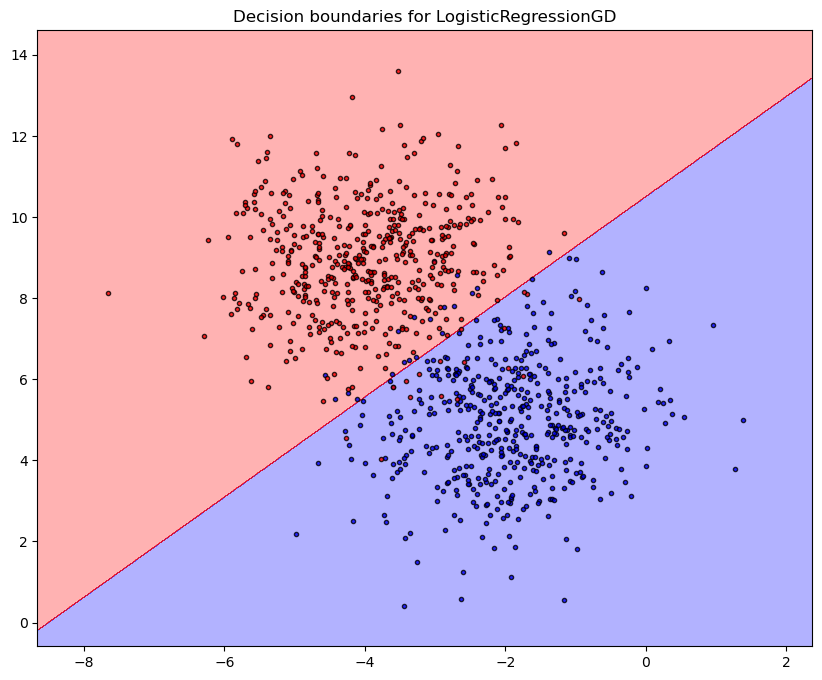

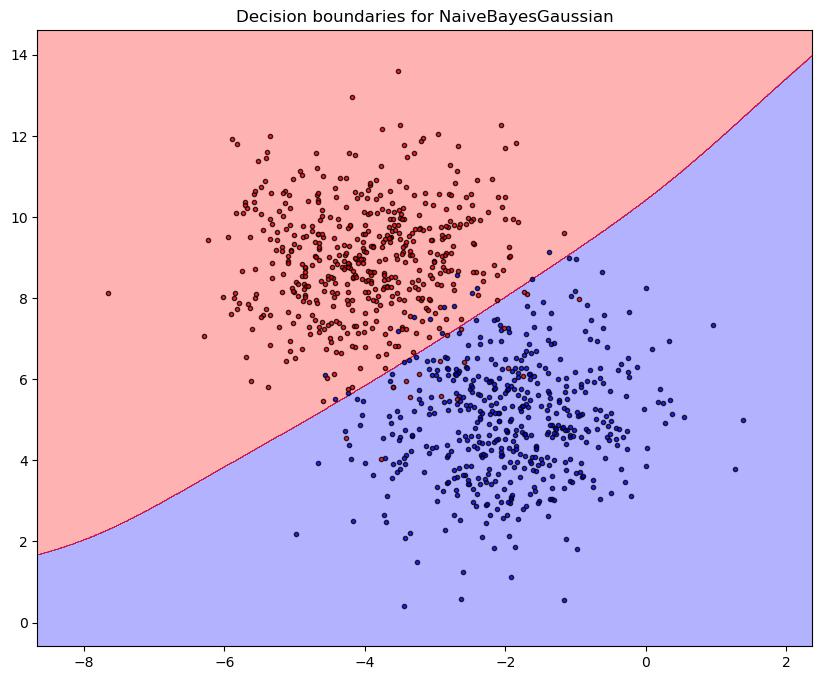

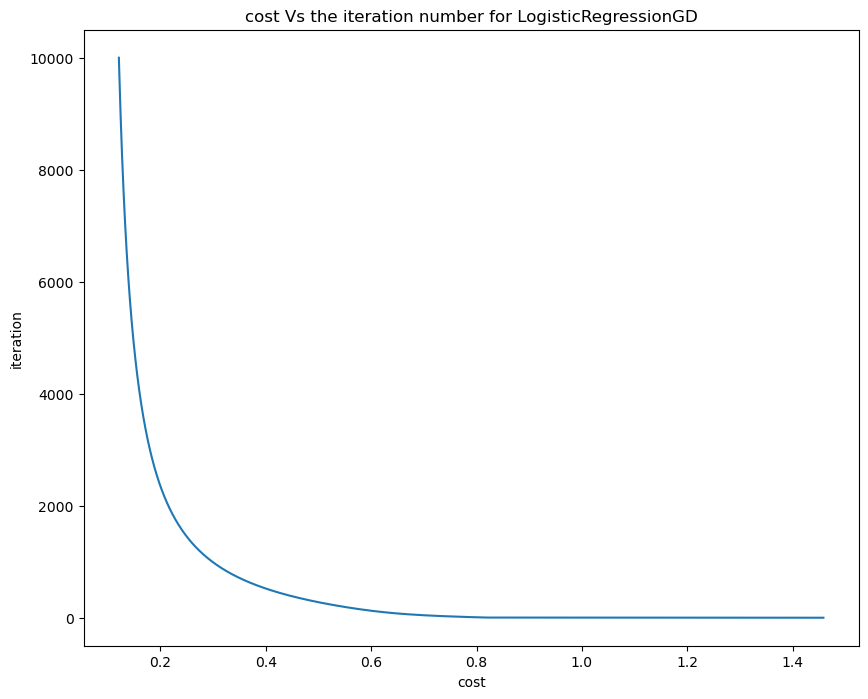

{'lor_train_acc': 96.5,
 'lor_test_acc': 93.8,
 'bayes_train_acc': 96.8,
 'bayes_test_acc': 94.2}

In [41]:
# Train - 1000, Test - 500
X_training_1000 = X_training[:1000, :]
y_training_1000 = y_training[:1000]

X_test_500 = X_test[:500, :]
y_test_500 = y_test[:500]

model_evaluation(X_training_1000, y_training_1000, X_test_500, y_test_500, 1, best_eta, best_eps)

#Graph 1: In the above graph we can see a a seperator (not linear seperability as some data points will not be classified correctly. 
# From the graph we can that the graph is seperating the datapoints.

#Graph 2: As we're using NavieBayes for the classification of the datapoints, we can see the line is curving as we're assuming by the naive assumption that the features are independent from each other. 
# Thus, the sperator is expected to be different from before.

#Graph 3: As expected, the process is iterable and the cost/loss is decreasing as the learning process continues 
# as the model learn better weights for the model.

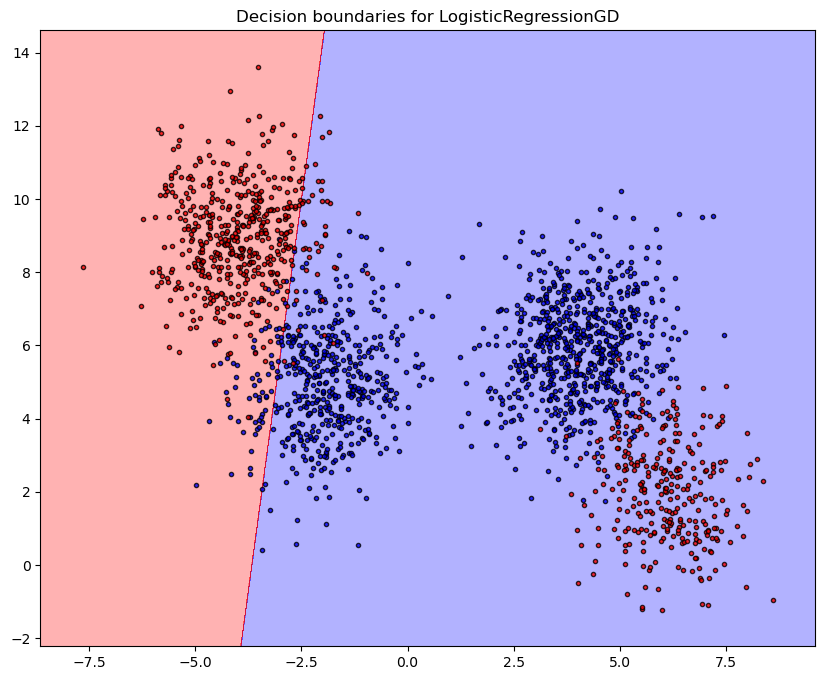

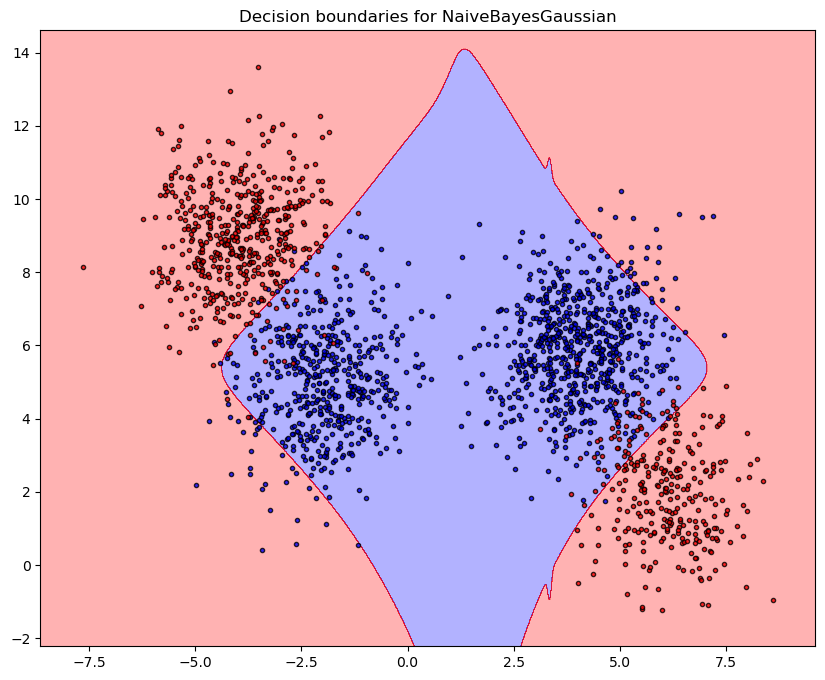

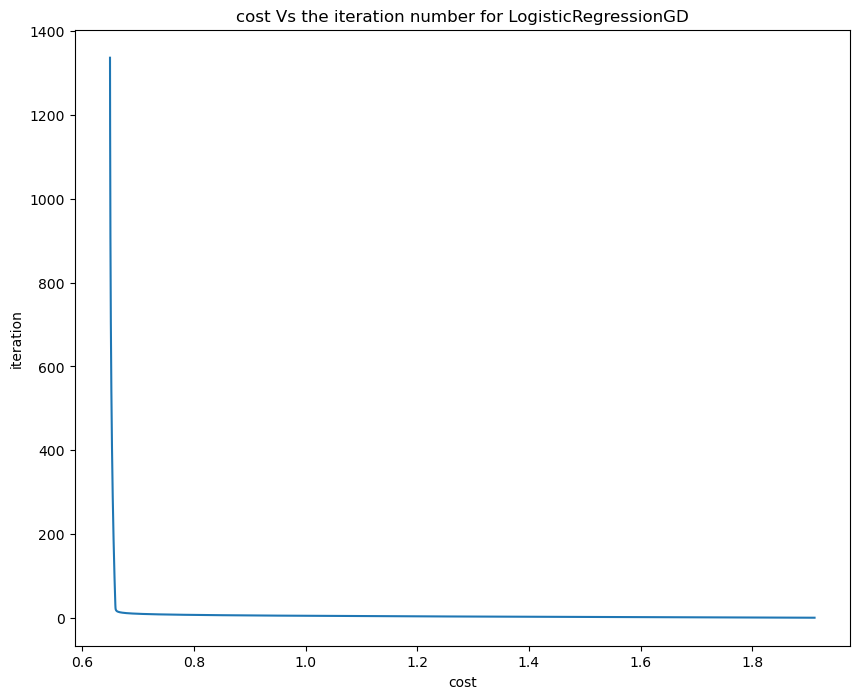

{'lor_train_acc': 79.6,
 'lor_test_acc': 79.2,
 'bayes_train_acc': 92.15,
 'bayes_test_acc': 90.1}

In [42]:
# Full Data
model_evaluation(X_training, y_training, X_test, y_test, 2, best_eta, best_eps)

# Graph 1: As we're using gradient desent, we're finding the linear line that 
#separates the data with the lowest loss/cost. As we're running it on the whole dataset
#the function yield this model for the best prediction.

# Graph 2: We're using NaiveBayes for the classification of the data points,
#so the model we'll get is different from before, as we're finding a model that
#will seperate the model not based on a linear seperator.

#Graph 3: As expected, the process is iterable and the cost/loss is decreasing as the learning process continues 
# as the model learn better weights for the model.